# Modeling

In [13]:
# pcr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from ISLP.models import ModelSpec as MS
import sklearn.linear_model as skl
import sklearn.model_selection as skm
import numpy as np
import pandas as pd

df = pd.read_csv('cleaned_HK_AirBnB_Data.csv')

In [14]:
df.drop(['id', 'name', 'host_id', 'host_name'], axis=1, inplace=True)

In [15]:
design = MS(df.columns.drop('price')).fit(df)
X = np.asarray(design.fit_transform(df).drop('intercept', axis=1))
Y = np.array(df['price'])

In [16]:
print(design)

ModelSpec(terms=Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bedroom_count', 'bathroom_count', 'bed_count',
       'true_district_Central & Western', 'true_district_Eas...
       'true_district_Kwai Tsing', 'true_district_Kwun Tong',
       'true_district_North', 'true_district_Sai Kung',
       'true_district_Sha Tin', 'true_district_Sham Shui Po',
       'true_district_Southern', 'true_district_Tai Po',
       'true_district_Tsuen Wan', 'true_district_Tuen Mun',
       'true_district_Wan Chai', 'true_district_Wong Tai Sin',
       'true_district_Yau Tsim Mong', 'true_district_Yuen Long'],
      dtype='object'))


In [17]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)

In [18]:
pca = PCA(n_components=2) 
linreg = skl.LinearRegression()
scaler = StandardScaler(with_mean = True, with_std = True)
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([292.74852317, -40.65854326])

In [19]:
param_grid = {'pca__n_components': range(1, 20)} 
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

In [20]:
from matplotlib.pyplot import subplots

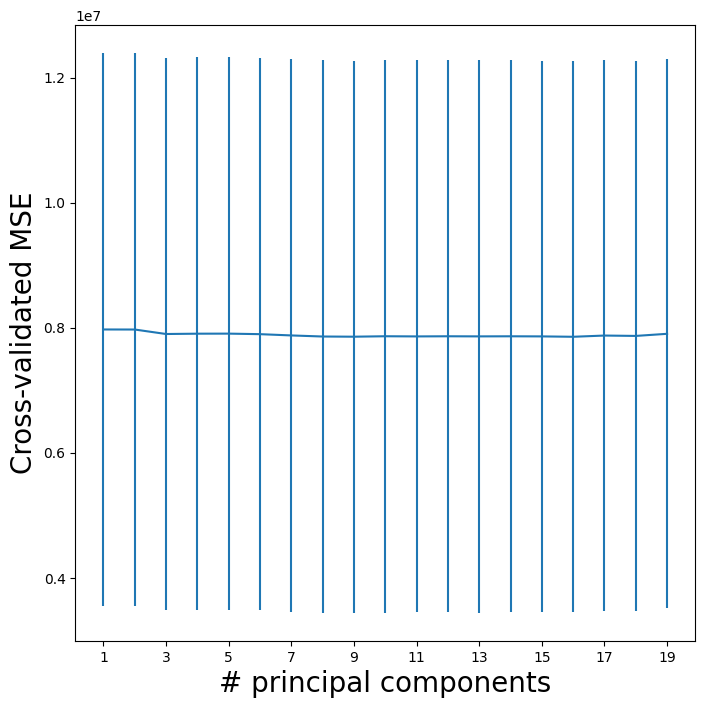

In [21]:
pcr_fig, ax = subplots(figsize=(8,8)) 
n_comp = param_grid['pca__n_components'] 
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K)) 
ax.set_ylabel('Cross-validated MSE', fontsize=20) 
ax.set_xlabel('# principal components', fontsize=20) 
ax.set_xticks(n_comp[::2])

In [22]:
# print the best number of components
print(grid.best_params_)

{'pca__n_components': 16}


In [23]:
Xn = np.zeros((X.shape[0], 1)) 
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold, scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

8228359.060269619

In [24]:
print(len(df.columns))

33


In [25]:
pca_components = pipe.named_steps['pca'].components_
linreg_coefficients = pipe.named_steps['linreg'].coef_

feature_contributions = np.dot(pca_components.T, linreg_coefficients)

feature_importance_ranking = np.argsort(np.abs(feature_contributions))[::-1]

print("Most Important Features by Contribution to Model:")
# print first 12 most important features
for rank in feature_importance_ranking[:12]:
    print(df.columns[rank], feature_contributions[rank])

Most Important Features by Contribution to Model:
room_type_Hotel room -119.1827302921336
number_of_reviews_ltm 115.50438654708958
number_of_reviews -113.21687025024714
bathroom_count 86.78375718647416
true_district_Eastern 83.41605483630697
calculated_host_listings_count -83.09116551179837
longitude -82.65078000004523
availability_365 66.35660450940338
minimum_nights 61.92326781608024
room_type_Shared room 59.062126239052404
bedroom_count 51.44040321434204
true_district_Tuen Mun -33.82180654723965


In [26]:
# Ridge

In [27]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# split a X and y test and train
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Elastic Net model
elastic_net = ElasticNet(random_state=0)

# Define the parameter grid to search over
param_grid_en = {
    'alpha': [0.1, 1, 10, 100], # You might need to adjust these values
    'l1_ratio': np.arange(0.0, 1.0, 0.1) # Adjusting the mix ratio
}

# Setup Grid Search with Cross-Validation
grid_search_en = GridSearchCV(estimator=elastic_net, param_grid=param_grid_en, cv=kfold, scoring='neg_mean_squared_error')

# Fit the model
grid_search_en.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_en.best_params_)

# Optionally, you can inspect the coefficients of the model
best_en_model = grid_search_en.best_estimator_
print("Coefficients of the best model:", best_en_model.coef_)

# Determine the most important features
feature_importance = np.abs(best_en_model.coef_)
important_features = np.argsort(feature_importance)[::-1]

print("Most Important Features by Elastic Net Model:")
for i in important_features[:12]: # Adjust the number to your preference
    print(df.columns[i], feature_importance[i])


C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e+10, tolerance: 4.340e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+10, tolerance: 2.719e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Best parameters found:  {'alpha': 0.1, 'l1_ratio': 0.1}
Coefficients of the best model: [-1.38886508e+01 -8.07858595e+00  7.56435539e-01  1.35249460e-01
 -2.85235777e+00  4.40299089e-01 -1.30849892e+01  2.27132932e+02
 -2.19765113e+01 -1.65679637e+02 -3.92544861e+01  2.13583180e+02
  1.75776526e+02  9.86532457e+01  1.97818785e+02 -1.41587530e+01
 -4.66610552e+01 -3.84696147e+01 -3.45439585e+00  1.41823856e+01
  5.04422024e+00 -1.87968919e+01 -3.28243061e+01 -6.02232905e+01
  1.49083552e+02 -2.08025224e+01  1.80041712e+02 -2.17396936e+01
 -1.26736626e+02  3.58303078e+00 -1.39131648e+02 -2.60882006e+01]
Most Important Features by Elastic Net Model:
number_of_reviews_ltm 227.13293247358587
room_type_Shared room 213.5831796092363
bed_count 197.81878491635325
true_district_Tai Po 180.0417121804781
bedroom_count 175.77652638316084
room_type_Hotel room 165.67963693122408
true_district_Sham Shui Po 149.08355151364273
true_district_Wong Tai Sin 139.13164809538515
true_district_Tuen Mun 126.7366

In [28]:
# print the mse
y_pred = grid_search_en.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

MSE:  792648.2685747537


In [29]:
# split a X and y test and train
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('regressor', LinearRegression())
])

# create a grid search
param_grid = {
    'pca__n_components': range(1, X.shape[1]+1),
}

grid = skm.GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

# print the best parameters
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

{'pca__n_components': 7}
0.07368551532385317
0.29156313483826246


In [30]:
# print mse
y_pred = grid.predict(X_test)
print(mean_squared_error(y_test, y_pred))

769896.6220262202


# CV

In [31]:
design = MS(df.columns.drop('price')).fit(df)
X = np.asarray(design.fit_transform(df).drop('intercept', axis=1))
Y = np.array(df['price'])

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from ISLP.models import ModelSpec as MS
import sklearn.linear_model as skl
import sklearn.model_selection as skm
import pandas as pd
import numpy as np

In [33]:
df = pd.read_csv(r"cleaned_HK_AirBnB_Data.csv")

In [34]:
df = df.drop(columns = ['id', 'name', 'host_id', 'host_name'], inplace = True)

In [35]:
# split a X and y test and train
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit a PCR model
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# fit a linear regression model
lm = LinearRegression()
lm.fit(X_train_pca, y_train)
y_pred = lm.predict(X_test_pca)

# fit a PCR model using pipeline and grid search
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('lm', LinearRegression())])
param_grid = {'pca__n_components': np.arange(1, X.shape[1]+1)}
grid = skm.GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

# calculate the MSE
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

AttributeError: 'NoneType' object has no attribute 'drop'

In [ ]:
# Assuming grid is your trained GridSearchCV object
best_model = grid.best_estimator_
pca = best_model.named_steps['pca']
lm = best_model.named_steps['lm']
components = pca.components_
lm_coefficients = lm.coef_
feature_importances = np.dot(components.T, lm_coefficients)
feature_names = X_train.columns
importance_series = pd.Series(feature_importances, index=feature_names).abs().sort_values(ascending=False)

# print the first 12
print(importance_series.head(12))


room_type_Entire home/apt         169.739542
bedroom_count                     160.307185
room_type_Private room            145.990745
bed_count                         144.655726
calculated_host_listings_count    133.211932
bathroom_count                    116.091258
availability_365                   97.079796
number_of_reviews                  83.758477
true_district_Sai Kung             76.950037
number_of_reviews_ltm              72.142744
true_district_Sham Shui Po         62.145718
true_district_Wan Chai             52.264831
dtype: float64


# ridge

In [ ]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define the Elastic Net model
elastic_net = ElasticNet(random_state=0)

# Define the parameter grid to search over
param_grid_en = {
    'alpha': [0.1, 1, 10, 100], # You might need to adjust these values
    'l1_ratio': np.arange(0.0, 1.0, 0.1) # Adjusting the mix ratio
}

# Setup Grid Search with Cross-Validation
grid_search_en = GridSearchCV(estimator=elastic_net, param_grid=param_grid_en, cv=kfold, scoring='neg_mean_squared_error')

# Fit the model
grid_search_en.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_en.best_params_)

# Optionally, you can inspect the coefficients of the model
best_en_model = grid_search_en.best_estimator_
print("Coefficients of the best model:", best_en_model.coef_)

# Determine the most important features
feature_importance = np.abs(best_en_model.coef_)
important_features = np.argsort(feature_importance)[::-1]

print("Most Important Features by Elastic Net Model:")
for i in important_features[:12]: # Adjust the number to your preference
    print(df.columns[i], feature_importance[i])

# print the MSE
y_pred = grid_search_en.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print(MSE)


C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e+10, tolerance: 4.340e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+10, tolerance: 2.719e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Best parameters found:  {'alpha': 0.1, 'l1_ratio': 0.1}
Coefficients of the best model: [-1.38886508e+01 -8.07858595e+00  7.56435539e-01  1.35249460e-01
 -2.85235777e+00  4.40299089e-01 -1.30849892e+01  2.27132932e+02
 -2.19765113e+01 -1.65679637e+02 -3.92544861e+01  2.13583180e+02
  1.75776526e+02  9.86532457e+01  1.97818785e+02 -1.41587530e+01
 -4.66610552e+01 -3.84696147e+01 -3.45439585e+00  1.41823856e+01
  5.04422024e+00 -1.87968919e+01 -3.28243061e+01 -6.02232905e+01
  1.49083552e+02 -2.08025224e+01  1.80041712e+02 -2.17396936e+01
 -1.26736626e+02  3.58303078e+00 -1.39131648e+02 -2.60882006e+01]
Most Important Features by Elastic Net Model:
number_of_reviews_ltm 227.13293247358587
room_type_Shared room 213.5831796092363
bed_count 197.81878491635325
true_district_Tai Po 180.0417121804781
bedroom_count 175.77652638316084
room_type_Hotel room 165.67963693122408
true_district_Sham Shui Po 149.08355151364273
true_district_Wong Tai Sin 139.13164809538515
true_district_Tuen Mun 126.7366

# subset selection

In [ ]:
import time
import itertools
# import sm.OLS
import statsmodels.api as sm

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [ ]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model